# Obligatorio: Curso Análisis Predictivo de Series Temporales

## Posgrado de Analítica de Big Data

## Universidad ORT Uruguay

### Curso 2021

**Integrantes:** 

 * Mauricio Martinez
 * Augusto Romero
 * Enrique Peirano (252190)

## Serie de consumo de Slots de una plataforma analítica de datos (Big Query)

Para este trabajo usaremos la serie temporal del uso de slots de un proyecto de Big Query. Big Query es un motor analítico de tipo SaaS que forma parte de las herramientas de Google Cloud Platform. Se trata de un servicio serverless que permite a las organizaciones administrarlo y controlar sus costos en base a distintos modelos de pricing.
El modelo que nos interesa analizar es el de los llamados "slots". En Big Query un "slot" es una unidad de procesamiento (similar a un cpu virtual). Las consultas analíticas que se realizan sobre la plataforma son procesadas por slots y éstos son asignados por la plataforma de acuerdo a la demanda, la disponibilidad y la complejidad de las consultas.
Nuestra serie de datos representa el uso de slots por intervalo de tiempo (medido en milisegundos de uso). Ejemplo: si en un intervalo de un segundo se registra un uso de 1500ms de slots podemos decir que se usaron 1.5 slots. Si bien esta es la unidad de medida original, para este trabajo decidimos realizar una modificación en el muestreo (los intervalos son de 5 minutos) y la unidad de medida es la cantidad de slots utilizados.


 * Tomamos el mes de mayo 2021
 
 * Los Slots se pueden comprar cada 5 minutos, por lo que decidimos trabajar con esa unidad de tiempo
 
 * t = 21 días hábiles * 288 (1 dia) = 6048 total 
 
 * Dividimos la serie entre Train y Test


### Paquetes:

In [27]:
install.packages('Metrics')
library('astsa')
library(forecast)
library('Metrics')

options(repr.plot.width=14, repr.plot.height=6)


Installing package into 'C:/Users/Quique/Documents/R/win-library/3.6'
(as 'lib' is unspecified)


package 'Metrics' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Quique\AppData\Local\Temp\RtmpqwSD8o\downloaded_packages


Warning message:
"package 'Metrics' was built under R version 3.6.3"
Attaching package: 'Metrics'

The following object is masked from 'package:forecast':

    accuracy



In [2]:
setwd('./')
ts_df <- read.csv("./data/proyectos_analiticos_20210501-20210531_no_weekends_resampled.csv")

In [3]:
ts_df <- ts_df[,2]
x = ts(ts_df, start=0 , frequency=1)
x = x/300000 # paso la unidad a slots
ts_df = ts_df/300000 # paso la unidad a slots
ts_df = ts(ts_df, start=0, frequency=1)

In [7]:
length(ts_df)

[1] 6048

### La Serie

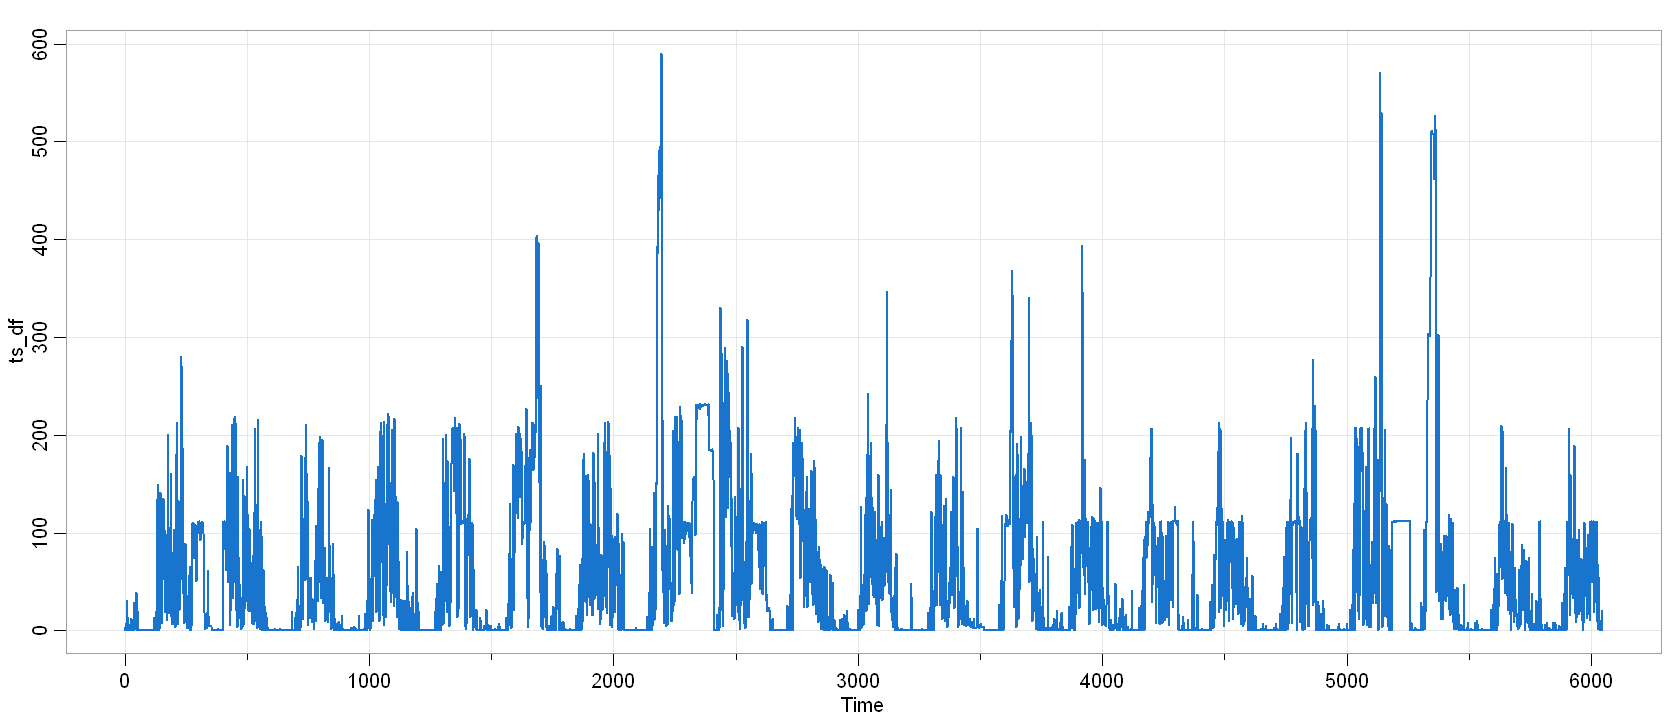

In [54]:
tsplot(ts_df, col=4, lwd=2)

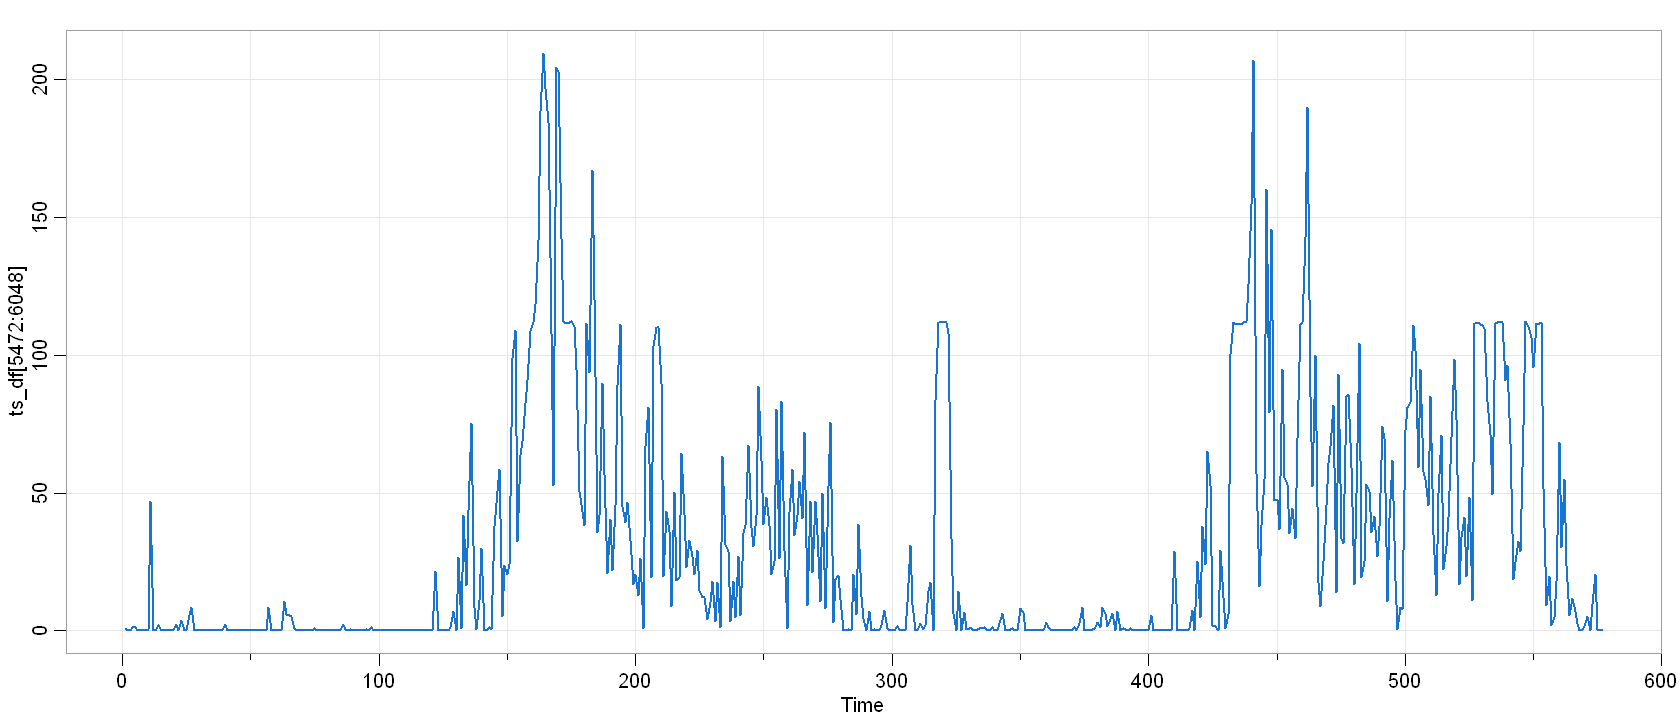

In [75]:
# Hacemos zoom para mostrar los últimos días que queremos predecir
tsplot(ts_df[5472:6048], col=4, lwd=2)

#### Particion Train-Test

In [56]:
start_train = 1000
start_test = 2950
time_series = ts_df

In [57]:
ret = c(0,0)

ts_length = length(time_series)        

end_train = start_test - 1

ts_df_train = ts(time_series[start_train:end_train], start=start_train-1, frequency=1)
ts_df_test = ts(time_series[start_test:ts_length], start=start_test-1, frequency=1)

dn = ts_df_train
dnt = ts_df_test


In [58]:
# Transformamos a log   
# agrego para probar +1 para evitar log(0)
ldn = log(dn+1)
ldnt = log(dnt+1)
t = time(ldn)


In [59]:
print(head(t))

Time Series:
Start = 999 
End = 1004 
Frequency = 1 
[1]  999 1000 1001 1002 1003 1004


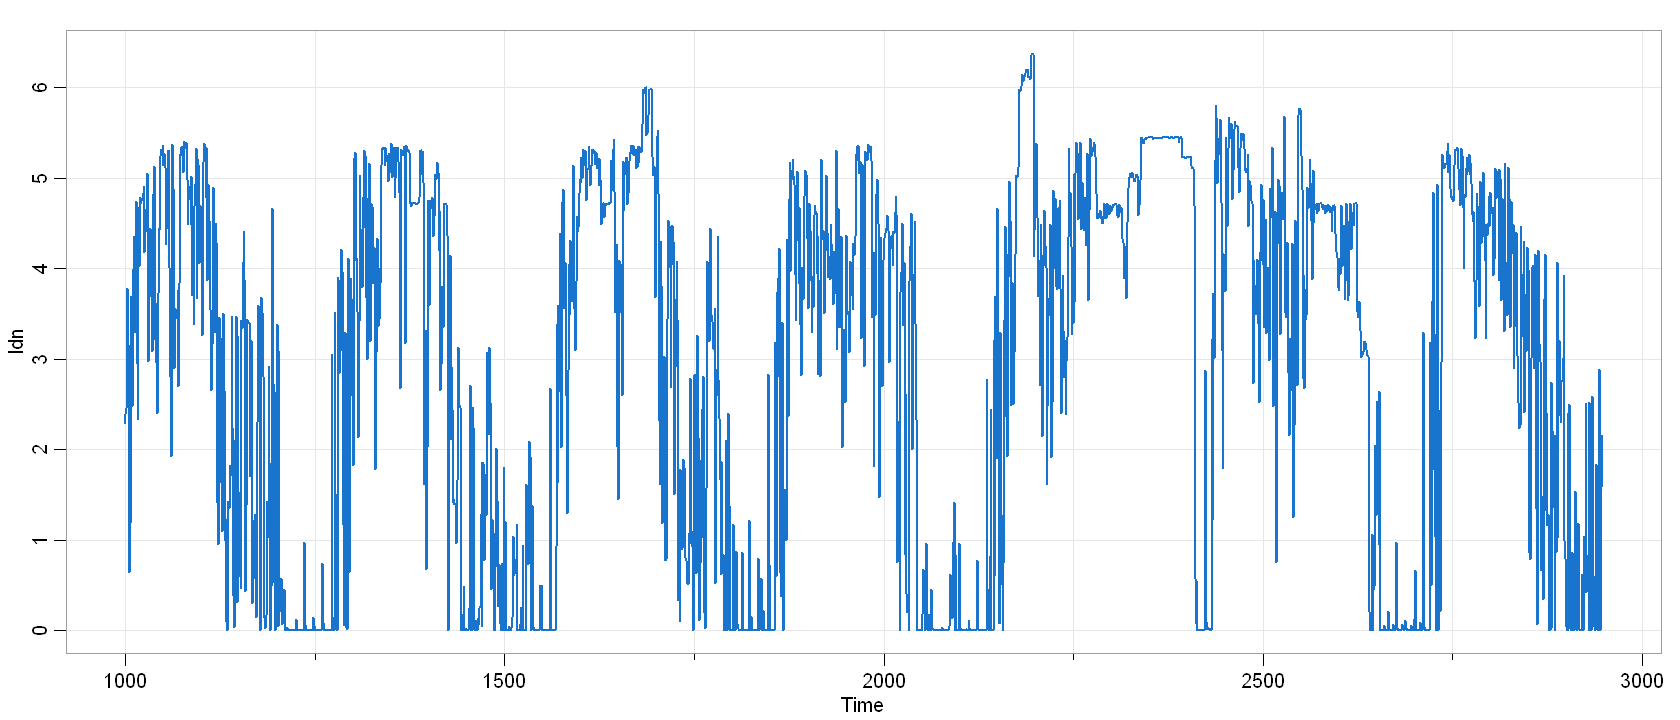

In [60]:
tsplot(ldn, col=4, lwd=2)

In [61]:
# nuevos datos para prediccion

new_t = seq(start_test-1,start_test-1,by=1)
new_t = ts(new_t,start=start_test-1,freq=1)
new_data = data.frame(t=new_t)

In [62]:
new_data

t
2949


### Tenencia

In [63]:
fittrn = lm(ldn ~ t, na.action=NULL)

#ndata <- data.frame(t = start_test-1)
ndata <- data.frame(t = new_data)


predict_trend = predict(fittrn,newdata=ndata)

predicttrend = ts(fitted(fittrn), start=start_train-1, freq=1)

#ldn = as.numeric(ldn)
ldnc = ldn-predicttrend

###
ldnc = ts(ldn-predicttrend, start=start_train-1, freq=1)
### 


In [64]:
summary(fittrn)


Call:
lm(formula = ldn ~ t, na.action = NULL)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2320 -2.3337  0.6539  1.7746  3.3555 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.428e+00  1.687e-01  14.390  < 2e-16 ***
t           2.729e-04  8.223e-05   3.319  0.00092 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.044 on 1948 degrees of freedom
Multiple R-squared:  0.005623,	Adjusted R-squared:  0.005113 
F-statistic: 11.02 on 1 and 1948 DF,  p-value: 0.0009199


In [65]:
head(time(ldn))

ERROR while rich displaying an object: Error in if (many_rows) {: argumento tiene longitud cero

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.ts(obj)
9. repr_ts_

In [66]:
head(time(ldnc))

ERROR while rich displaying an object: Error in if (many_rows) {: argumento tiene longitud cero

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.ts(obj)
9. repr_ts_

In [67]:
head(time(predicttrend))

ERROR while rich displaying an object: Error in if (many_rows) {: argumento tiene longitud cero

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.ts(obj)
9. repr_ts_

In [68]:
head(time(ldnc))

ERROR while rich displaying an object: Error in if (many_rows) {: argumento tiene longitud cero

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.ts(obj)
9. repr_ts_

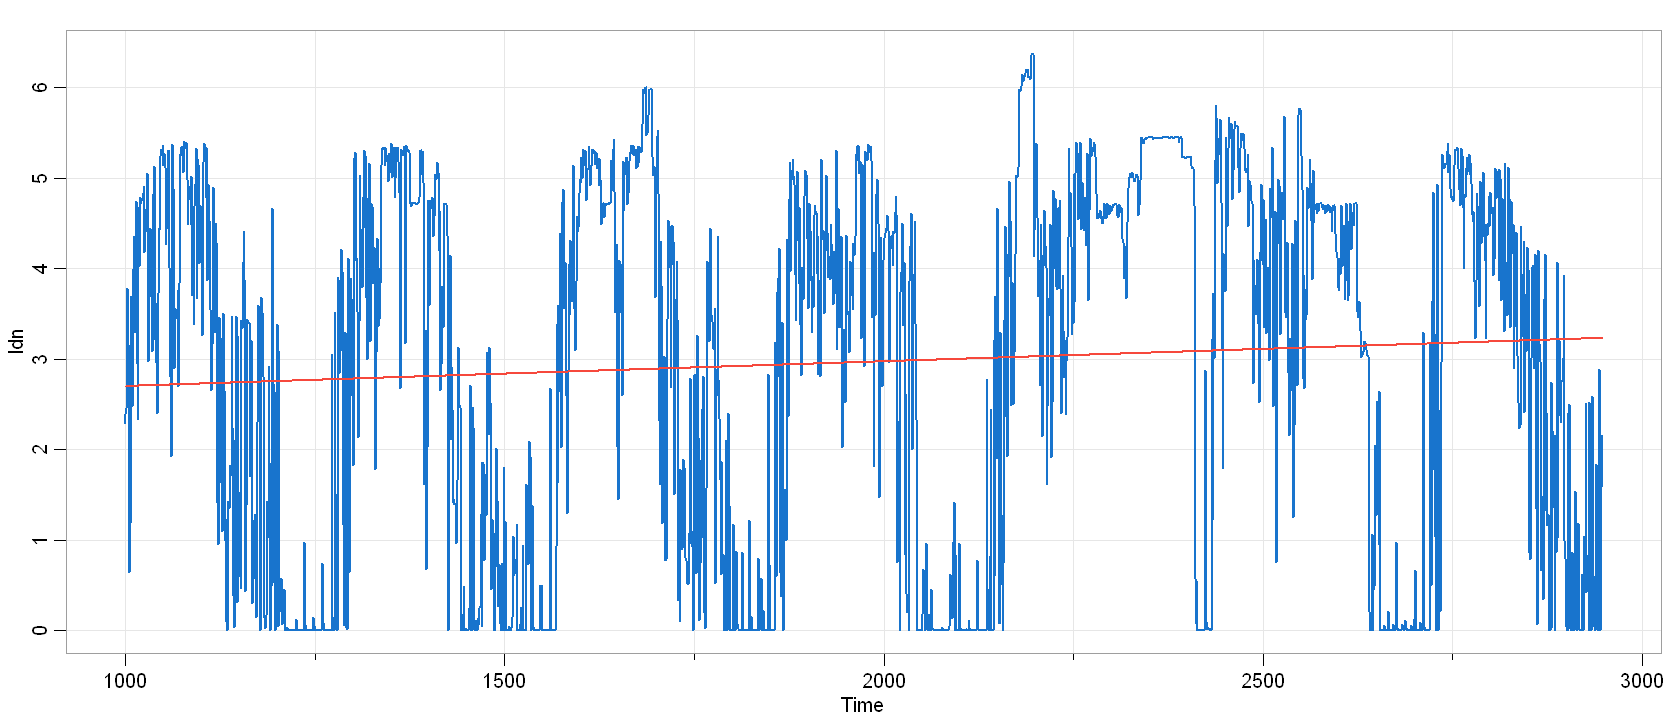

In [69]:
tsplot(ldn, col=4, lwd=2)
lines(predicttrend, col=2, lwd=2)

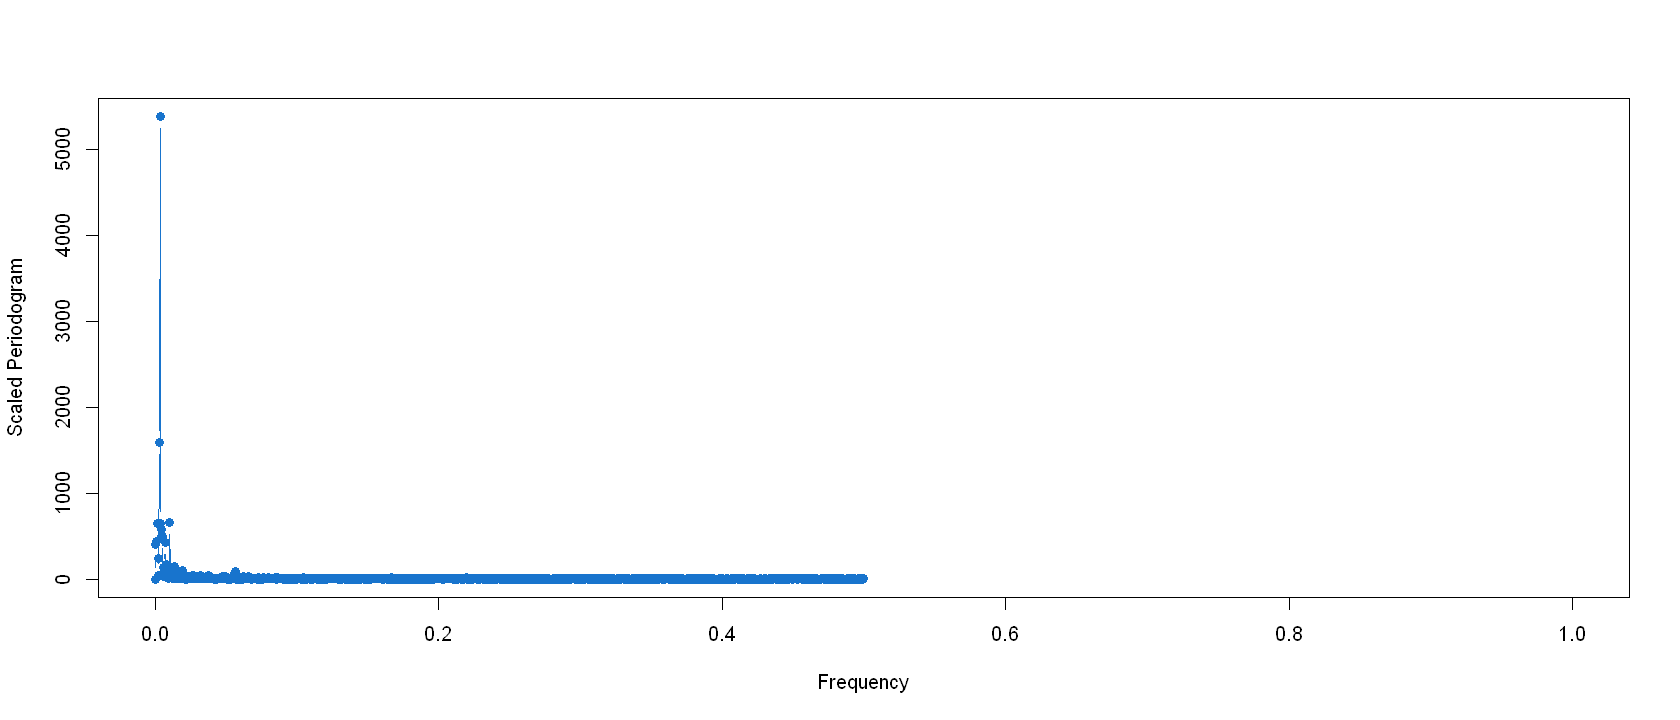

In [70]:
# Periodograma
n=length(ldnc)

P = 4/n*abs(fft(ldnc))^2 
P=P[1:floor(n/2)]#me quedo con las frecuencias posibles
f = (0:(n/2-1))/n #*12 ##El *12 es para llevarlo a la frecuencia original de la serie.
plot(f,P,  type="b", xlab="Frequency", ylab="Scaled Periodogram", xlim=c(0, 1), col=4, lwd=1, pch=19)

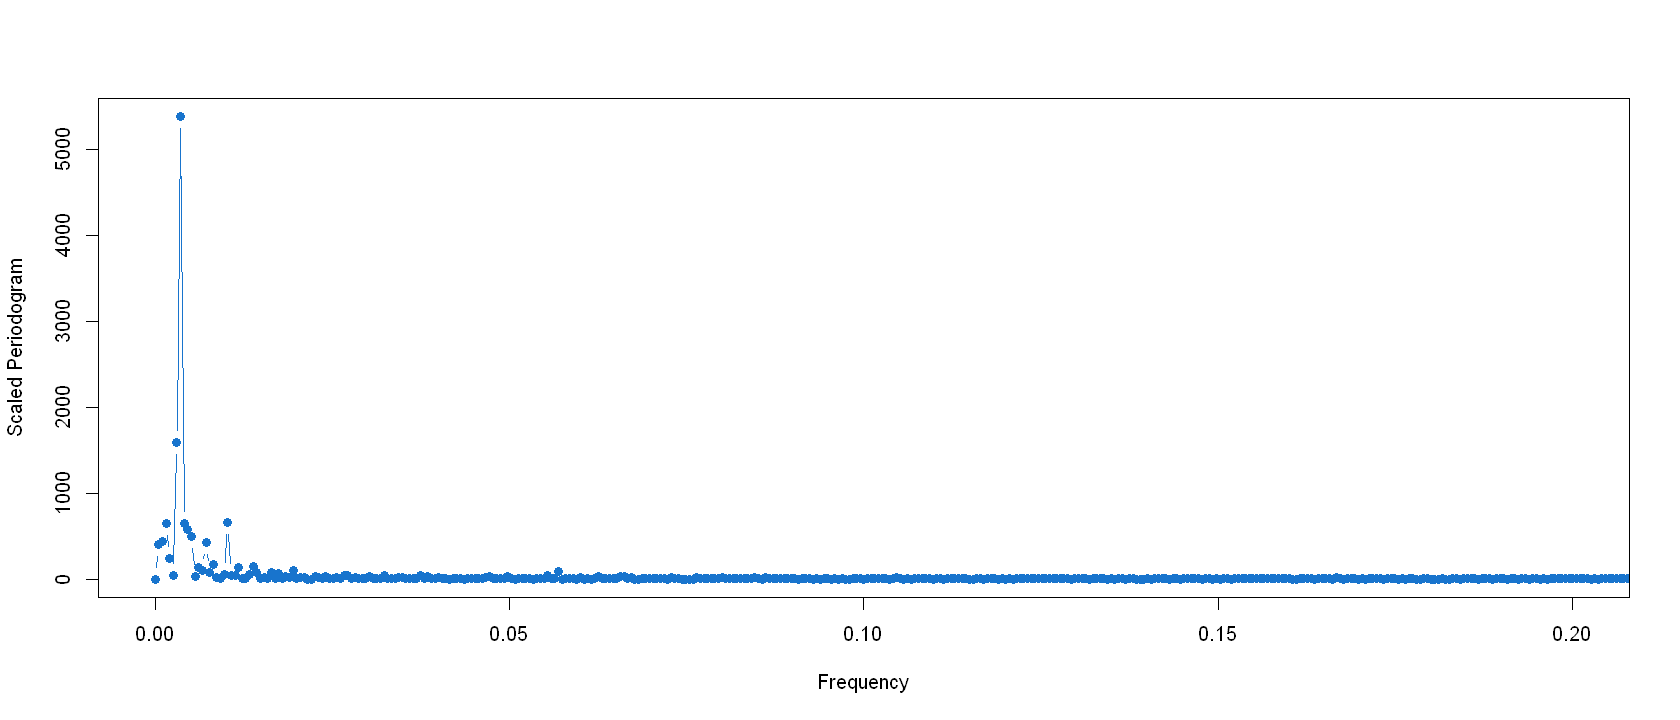

In [71]:
plot(f,P,  type="b", xlab="Frequency", ylab="Scaled Periodogram", xlim=c(0, 0.2), col=4, lwd=1, pch=19)

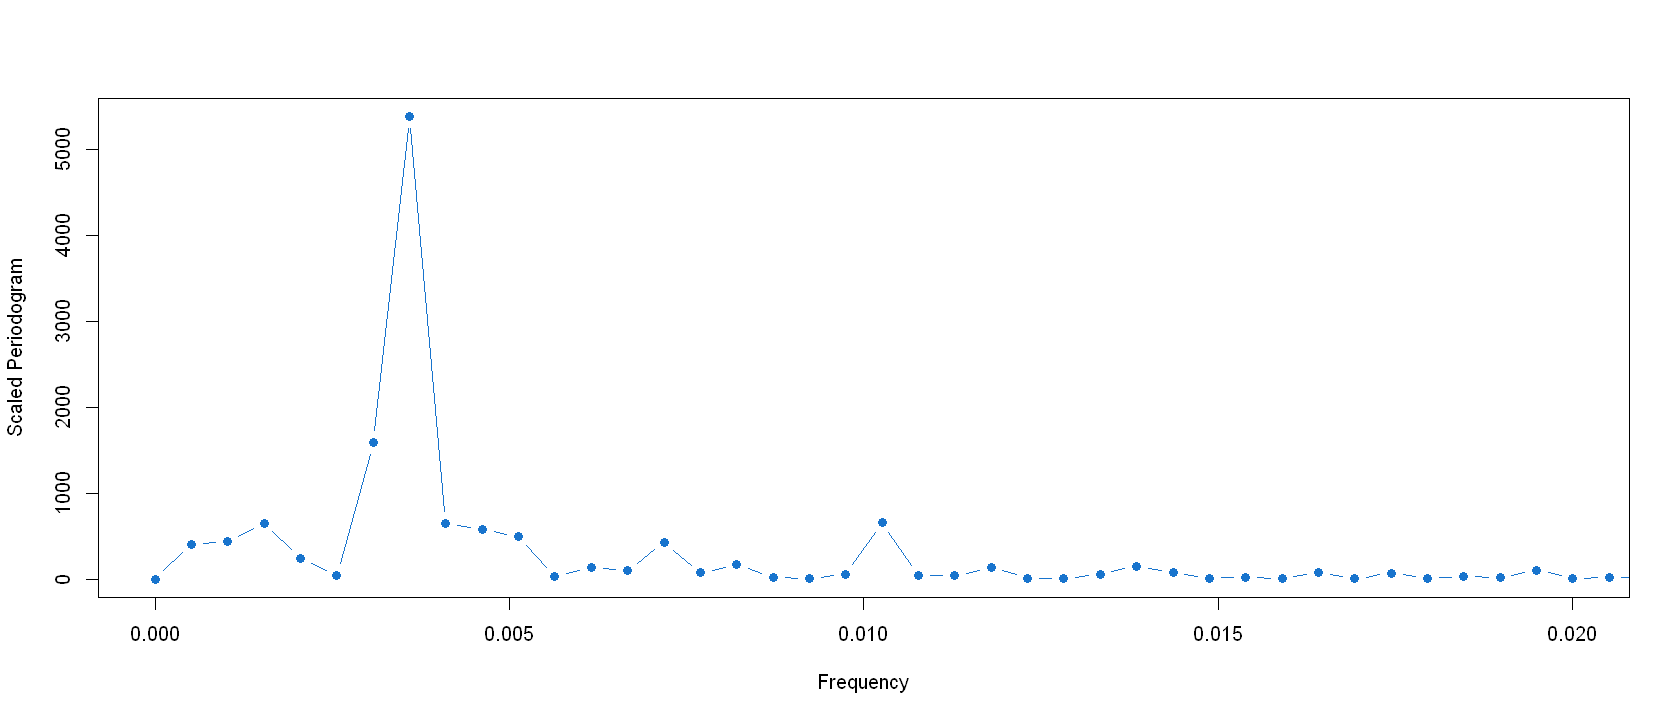

In [72]:
plot(f,P,  type="b", xlab="Frequency", ylab="Scaled Periodogram", xlim=c(0, 0.02), col=4, lwd=1, pch=19)

[1] "0.00307692307692308   1587.91092986285"
[1] "0.00358974358974359   5376.48179773608"


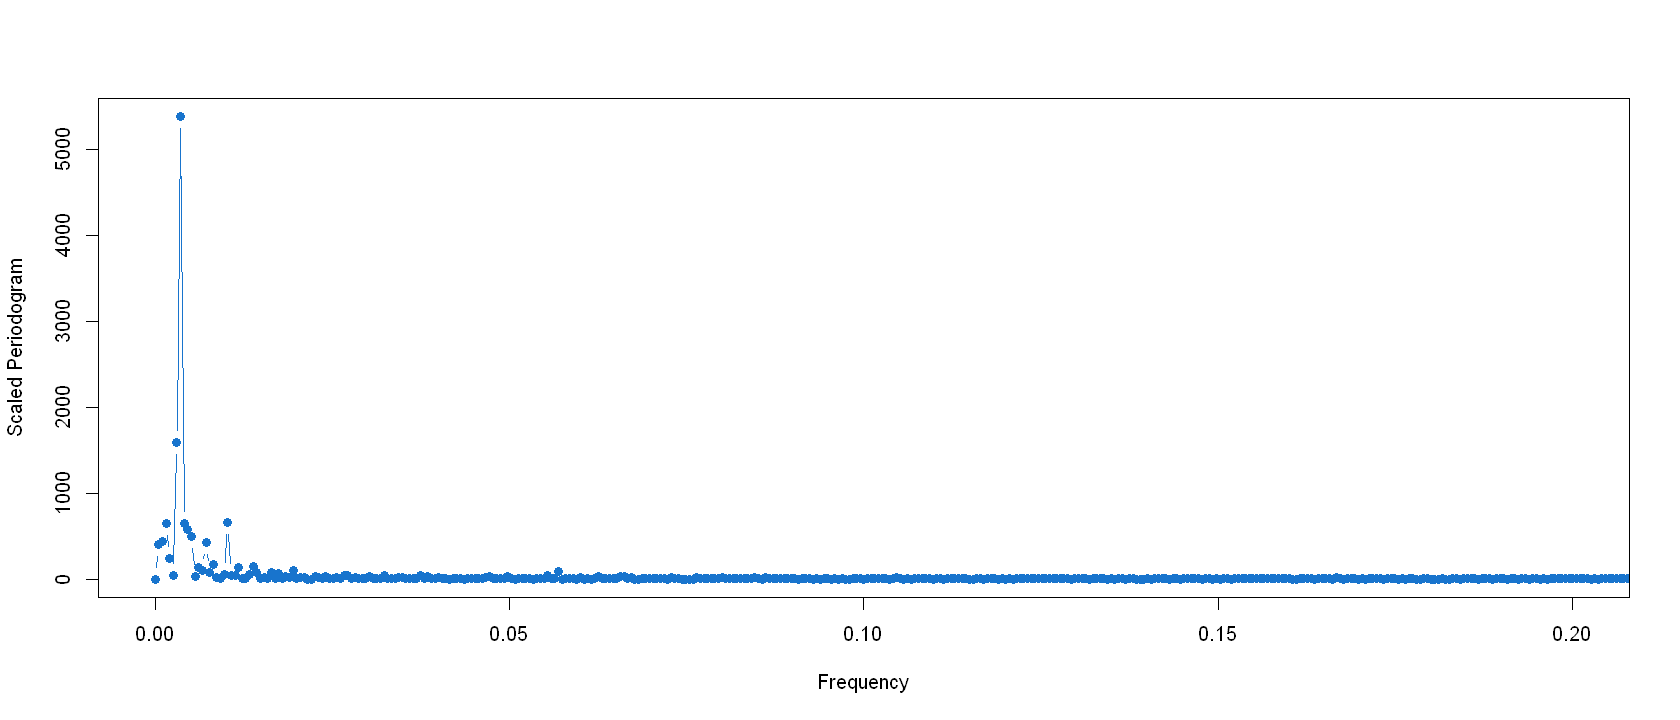

In [73]:
# imprimo de nuevo el periodograma de la serie original transformada
plot(f,P,  type="b", xlab="Frequency", ylab="Scaled Periodogram", xlim=c(0, 0.2), col=4, lwd=1, pch=19)

# me quedo con los valores de un umbral que defino a partir de las primeras observaciones del periodograma
# para elegir las frecuencias
# ajusto el limite de frecuencias a 0.4
P_thresh = 700 # umbral del eje y 
max_freq_idx = length(f)

for (i in (1:max_freq_idx)){
    if (P[i] > P_thresh & f[i] < .2) {
        print(paste(f[i], " " ,P[i]))
        }
}

In [74]:
t = time(ldnc) 


f1 =  0.003473

fit = lm(ldnc ~ 0 + cos(2*pi*f1*t) + sin(2*pi*f1*t) ,
         na.action=NULL)

prediction = ts(fitted(fit), start=start_train-1, freq=1)

#tn = ts_length
tn = start_test - 1 
        
v = 0 + cos(2*pi*f1*tn) + sin(2*pi*f1*tn) 

#vdf <- data.frame(t = v)
vdf <- data.frame(t = new_data)

fore_f = predict(fit, vdf)    

res = (ts(residuals(fit), start=start_train -1, freq=1))

   

In [33]:
summary(fit)


Call:
lm(formula = ldnc ~ 0 + cos(2 * pi * f1 * t) + sin(2 * pi * f1 * 
    t), na.action = NULL)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.2407 -1.2637 -0.1218  1.0071  4.2505 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
cos(2 * pi * f1 * t)  0.04228    0.04969   0.851    0.395    
sin(2 * pi * f1 * t) -1.87997    0.04999 -37.607   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.556 on 1948 degrees of freedom
Multiple R-squared:  0.4206,	Adjusted R-squared:   0.42 
F-statistic: 707.1 on 2 and 1948 DF,  p-value: < 2.2e-16


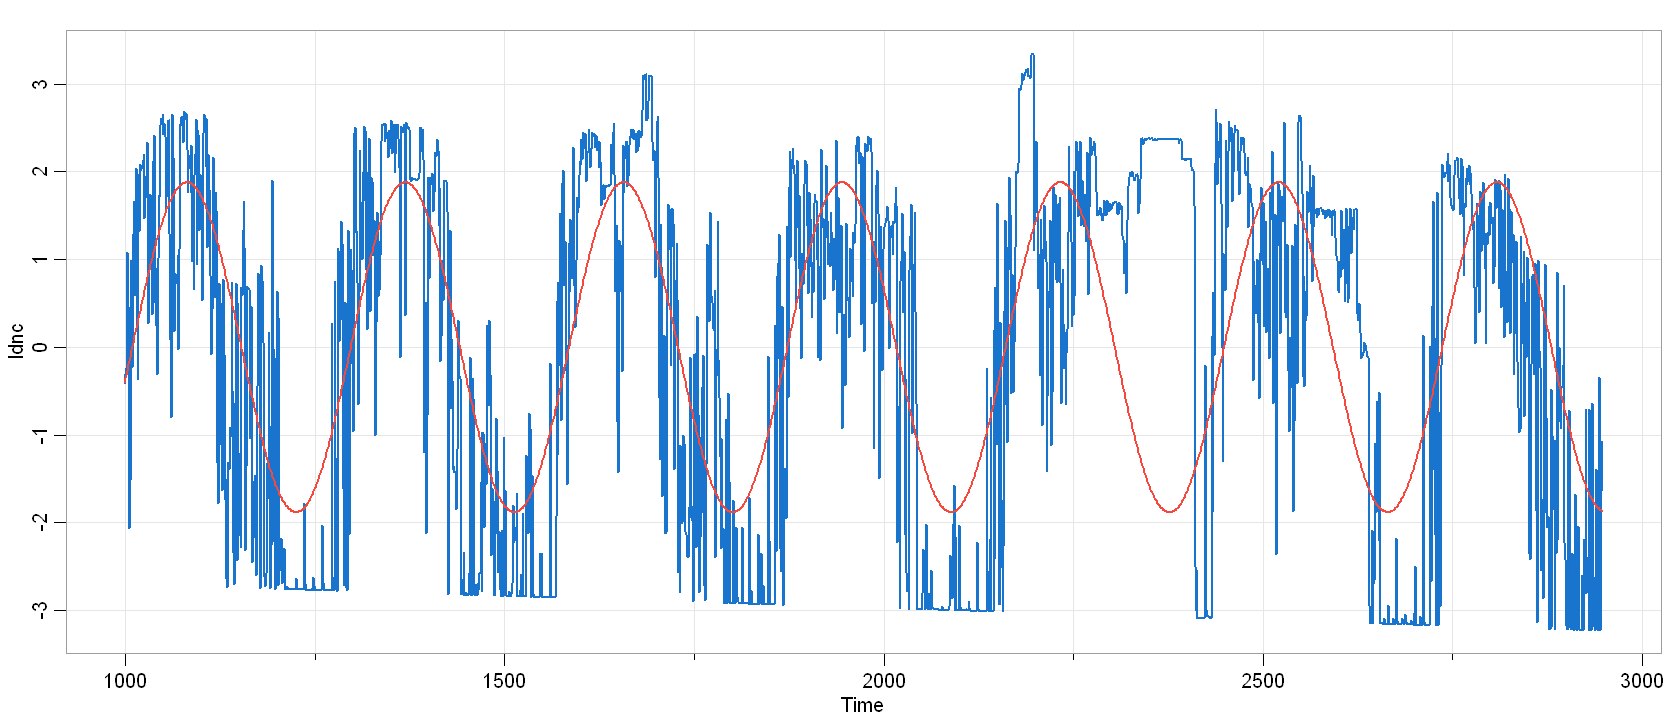

In [34]:
tsplot(ldnc, col=4, lwd=2)
lines(prediction, col=2, lwd=2)

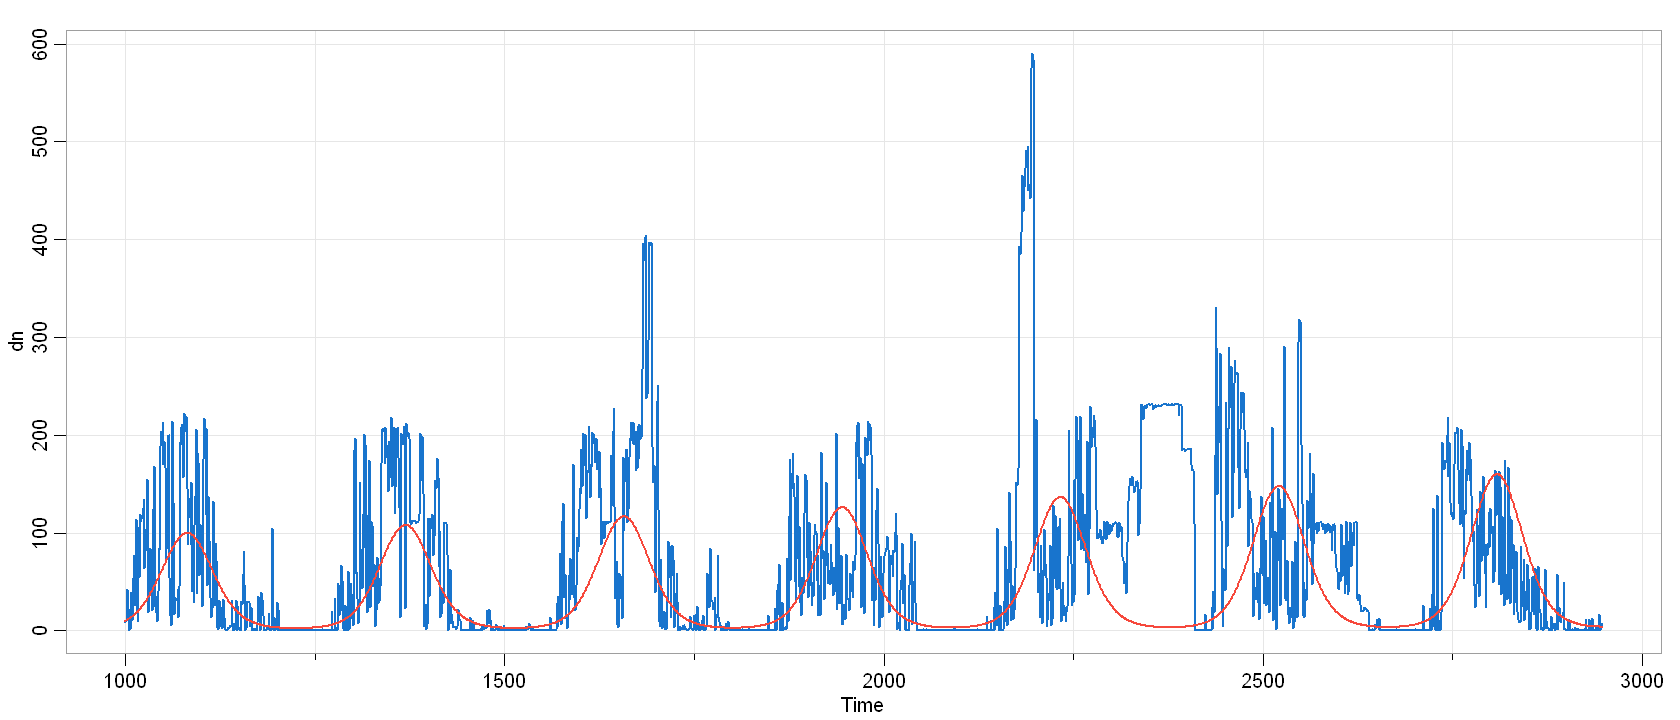

In [35]:
tsplot(dn, col=4, lwd=2)
lines(exp(prediction+predicttrend),col=2,lwd=2)

In [30]:
tail(time(prediction+predicttrend))

A Time Series:
[1] 2943 2944 2945 2946 2947 2948

In [36]:
new_t = seq(2949,3500,by=1)
new_t = ts(new_t,start=2949,freq=1)
new_data = data.frame(t=new_t)

In [37]:
predict_freq = predict(fit, new_data)
ts_predict_freq = ts(predict_freq,start=2949,freq=1)
#ts_predict_freq

In [38]:
predict_trnd = predict(fittrn, new_data)
ts_predict_trnd = ts(predict_trnd,start=2949,freq=1)

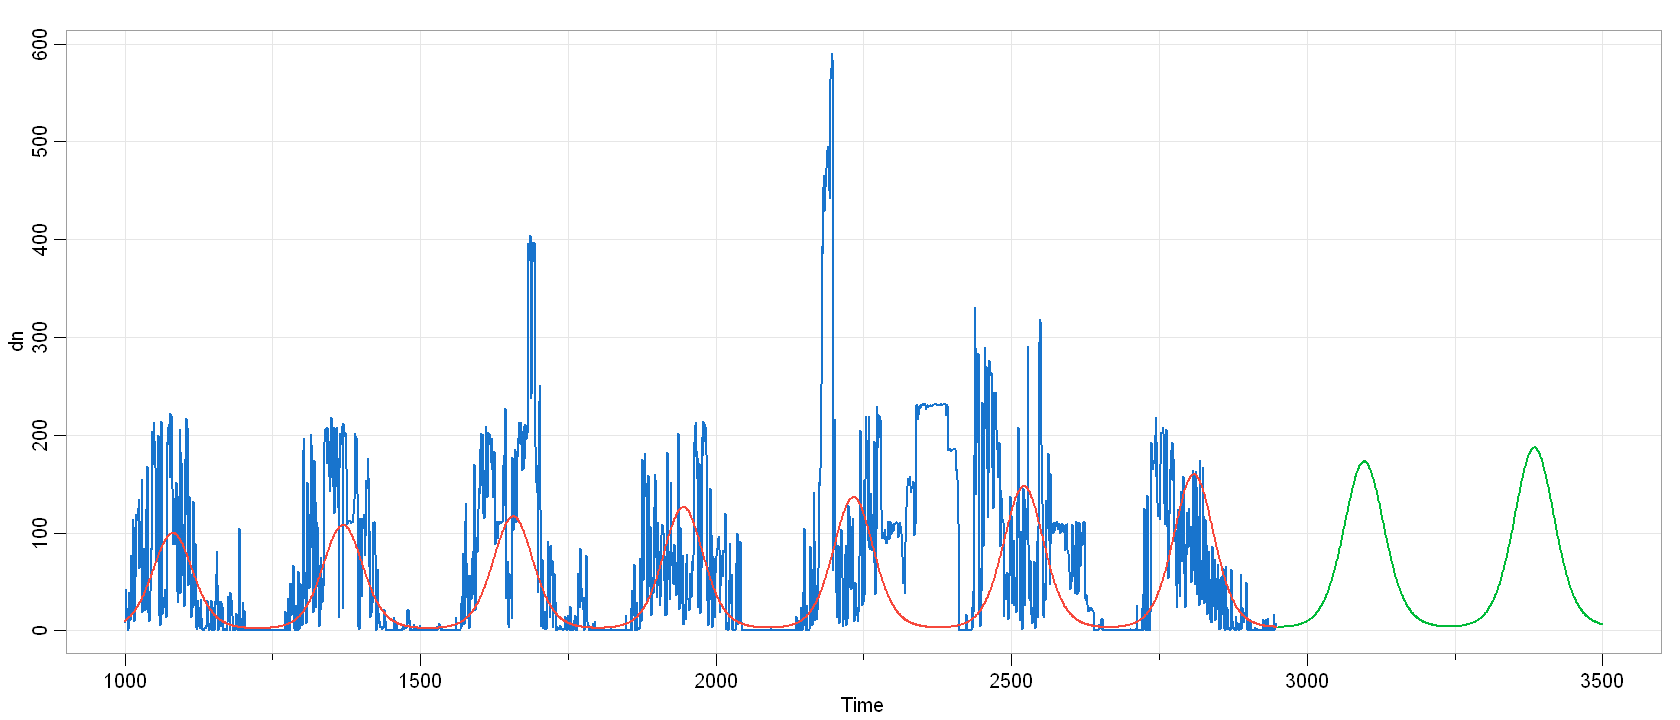

In [39]:
tsplot(dn, col=4, lwd=2, xlim=c(1000,3500))
lines(exp(prediction+predicttrend),col=2,lwd=2)
lines(exp(ts_predict_freq+ts_predict_trnd),col=3,lwd=2)

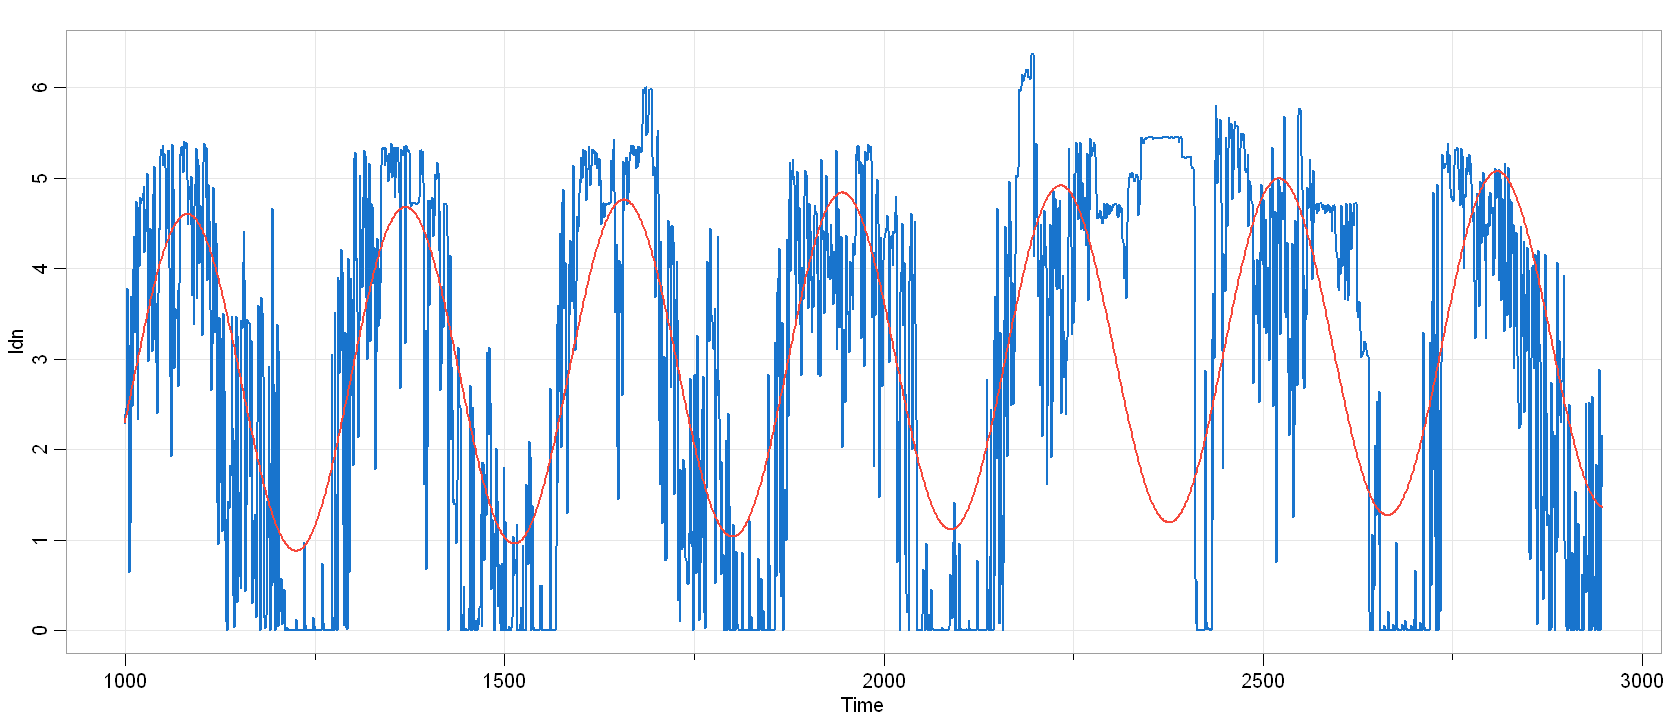

In [40]:
tsplot(ldn, col=4, lwd=2)
lines(prediction+predicttrend, col=2, lwd=2)

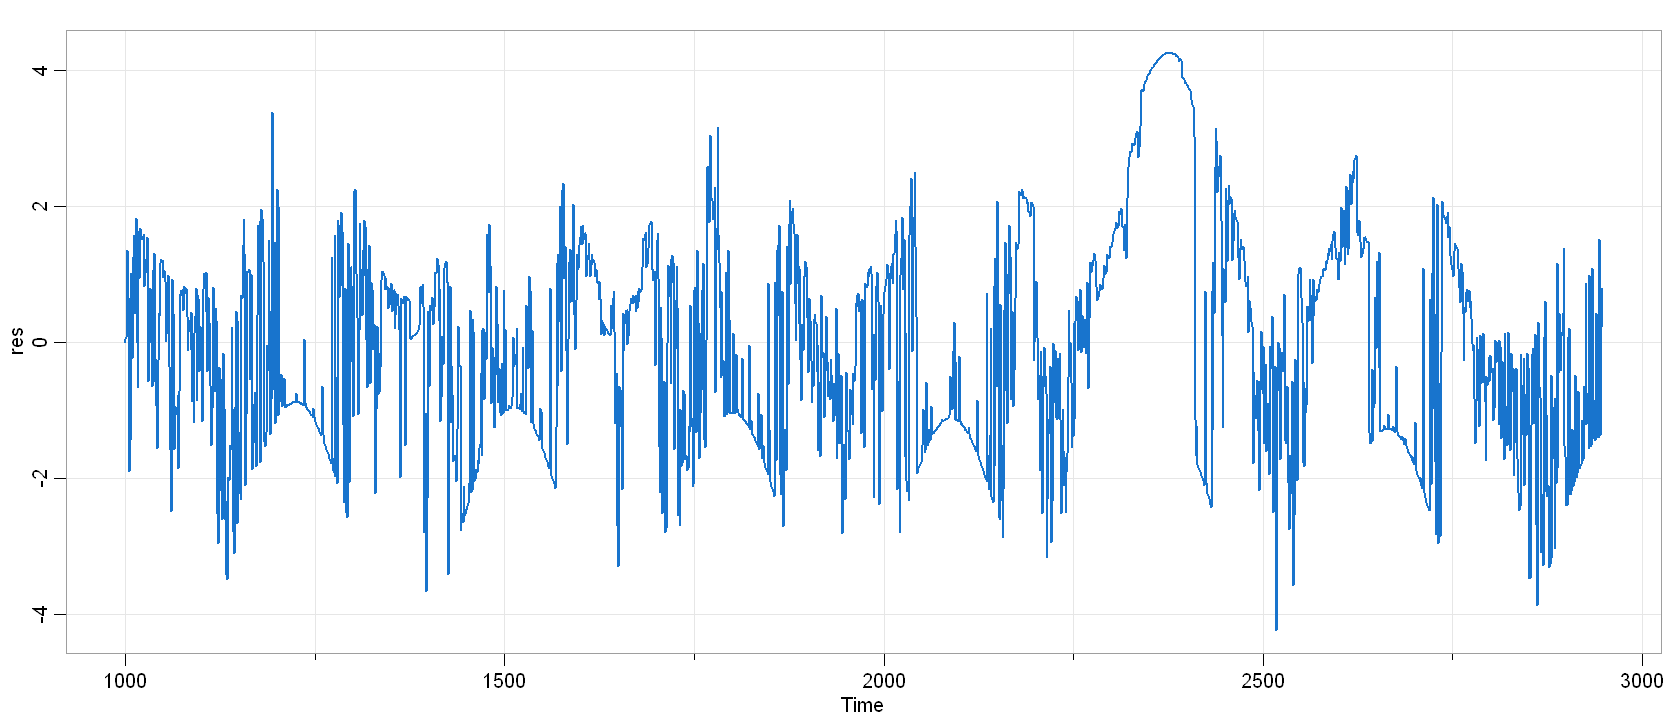

In [41]:
tsplot(res, col=4, lwd=2)

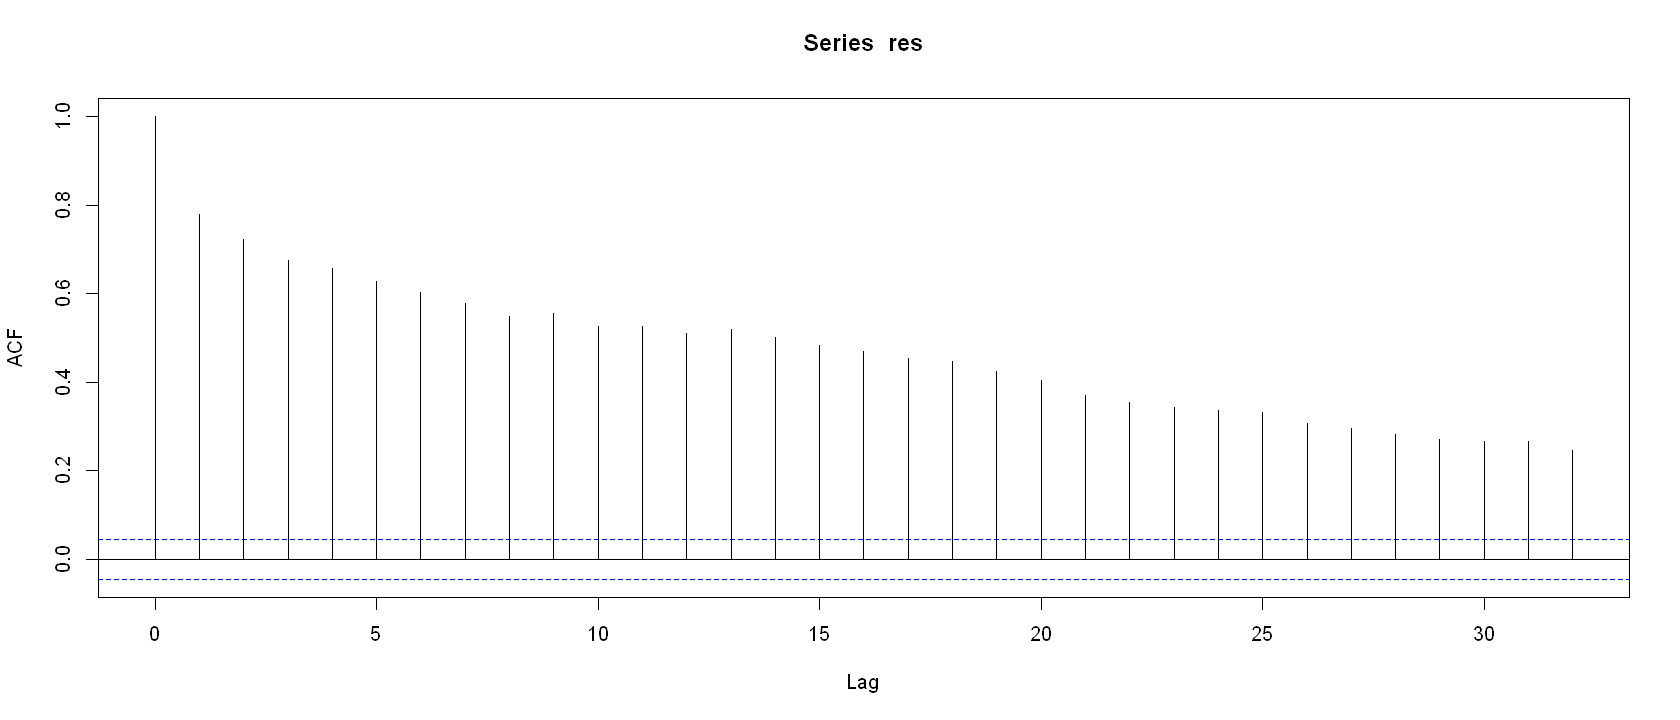

In [42]:
acf(res)

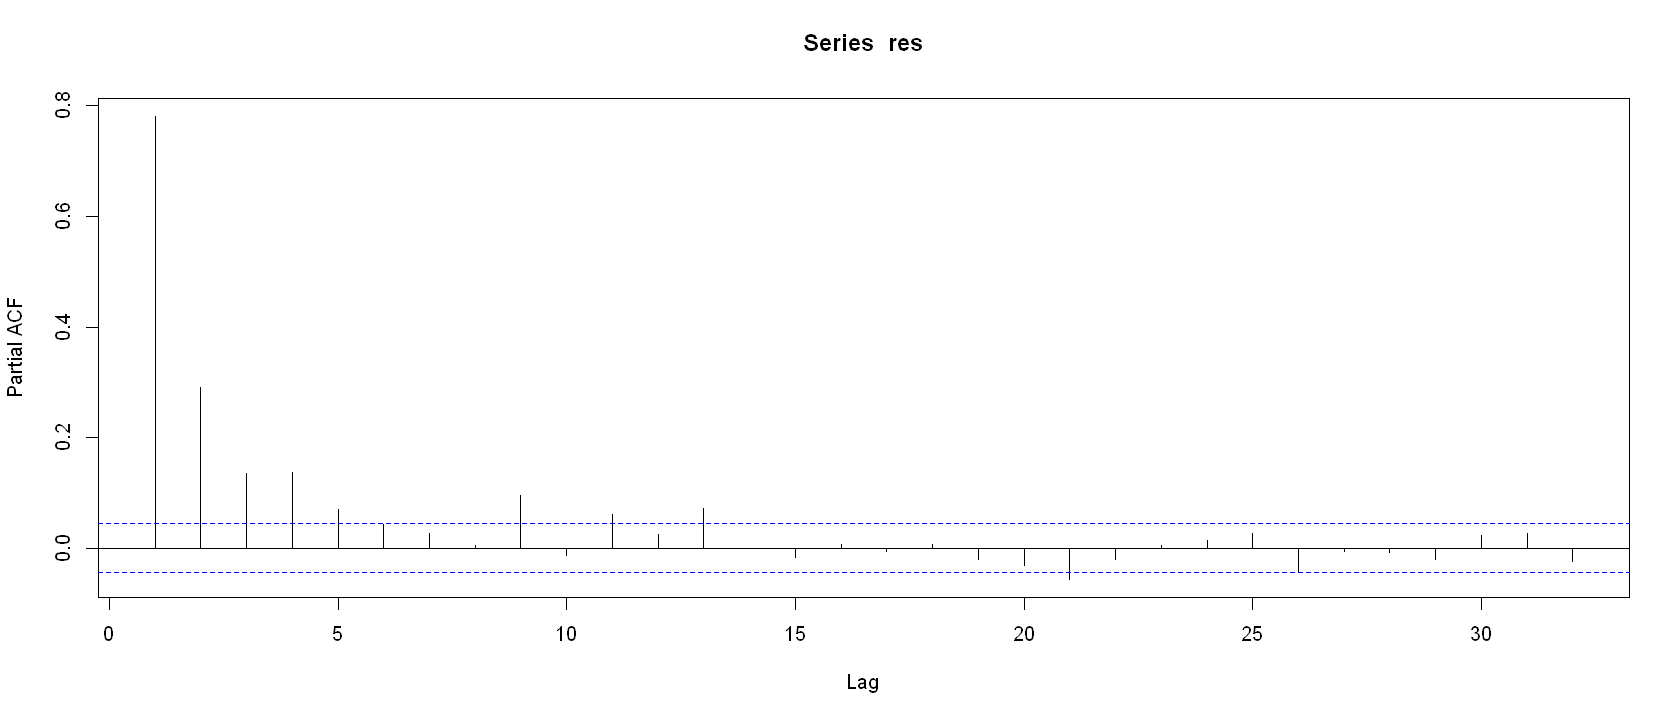

In [43]:
pacf(res)

In [44]:
ldncr1 = res
        
fit = Arima(ldncr1, order = c(5,0,0), include.mean=FALSE)
fore = forecast(fit, h=1)   

ldnt = as.numeric(ldnt)

e = exp(1)

ldnt = ts(ldnt, start=start_test -1, frequency=1)    

v_ldnt = ldnt #c + predictiont
v_pred = fore$mean + fore_f + predict_trend

v_ldnt = (e^v_ldnt) 
v_pred = (e^v_pred) -1 

v_ldnt[1:5]
v_pred[1:5]
ret = c(v_ldnt[1], v_pred[1], time(v_ldnt)[1], time(v_pred)[1],fore$mean,fore_f,predict_trend)
ret

[1]  8.801720 16.746083  7.113607  1.280477  1.026700

1     <NA>     <NA>     <NA>     <NA> 
4.824737       NA       NA       NA       NA

1                                               1 
   8.801720    4.824737 2949.000000 2949.000000    0.404439   -1.875367 
          1 
   3.233042

In [45]:
summary(fit)

Series: ldncr1 
ARIMA(5,0,0) with zero mean 

Coefficients:
         ar1     ar2     ar3     ar4     ar5
      0.4858  0.1806  0.0523  0.1025  0.0699
s.e.  0.0226  0.0250  0.0253  0.0251  0.0226

sigma^2 estimated as 0.8319:  log likelihood=-2585.57
AIC=5183.14   AICc=5183.18   BIC=5216.59

Training set error measures:
                       ME      RMSE       MAE       MPE     MAPE     MASE
Training set -0.004742781 0.9108934 0.6326805 -105.1331 317.3328 1.008396
                     ACF1
Training set -0.002676917


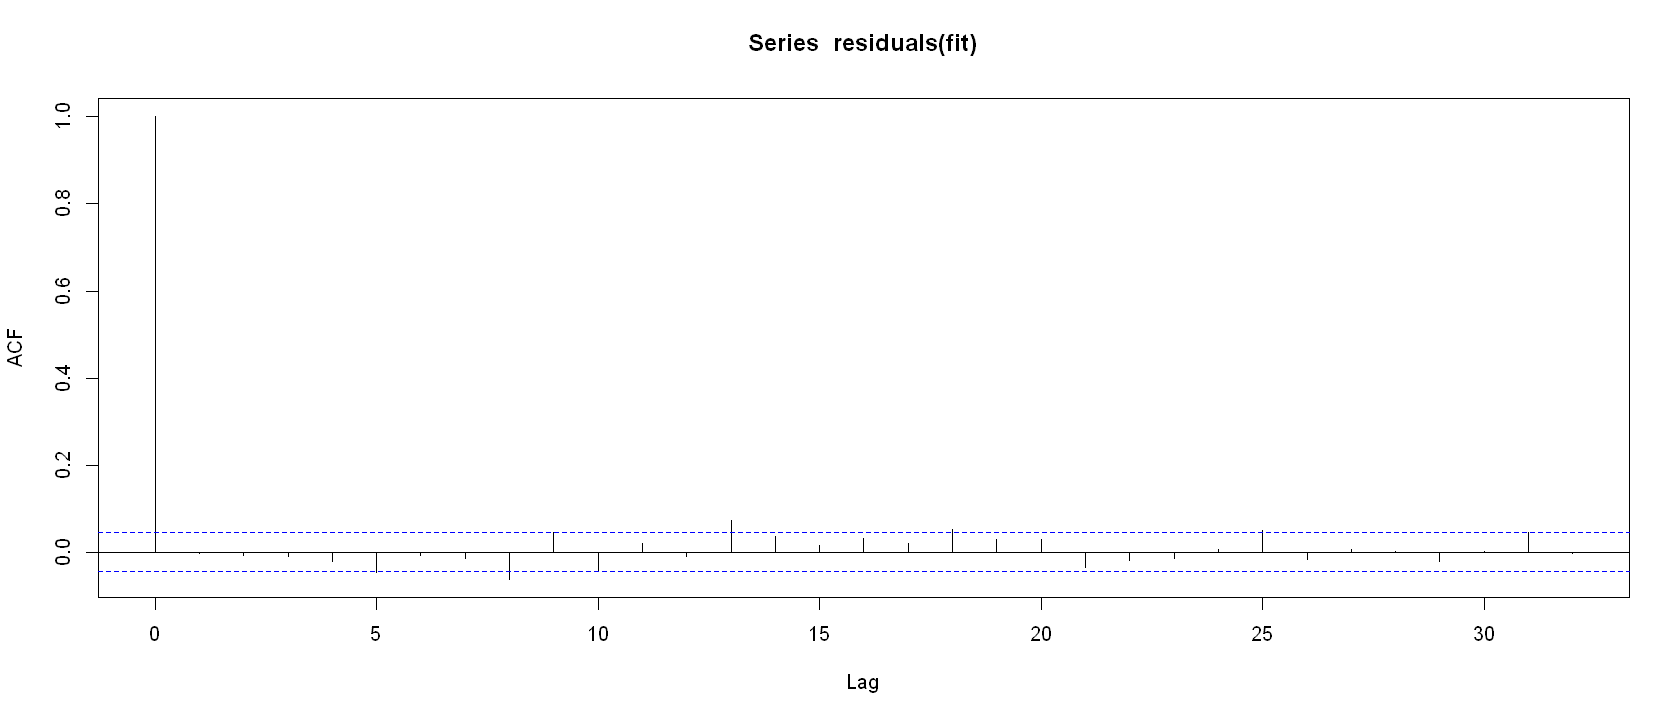

In [46]:
acf(residuals(fit))

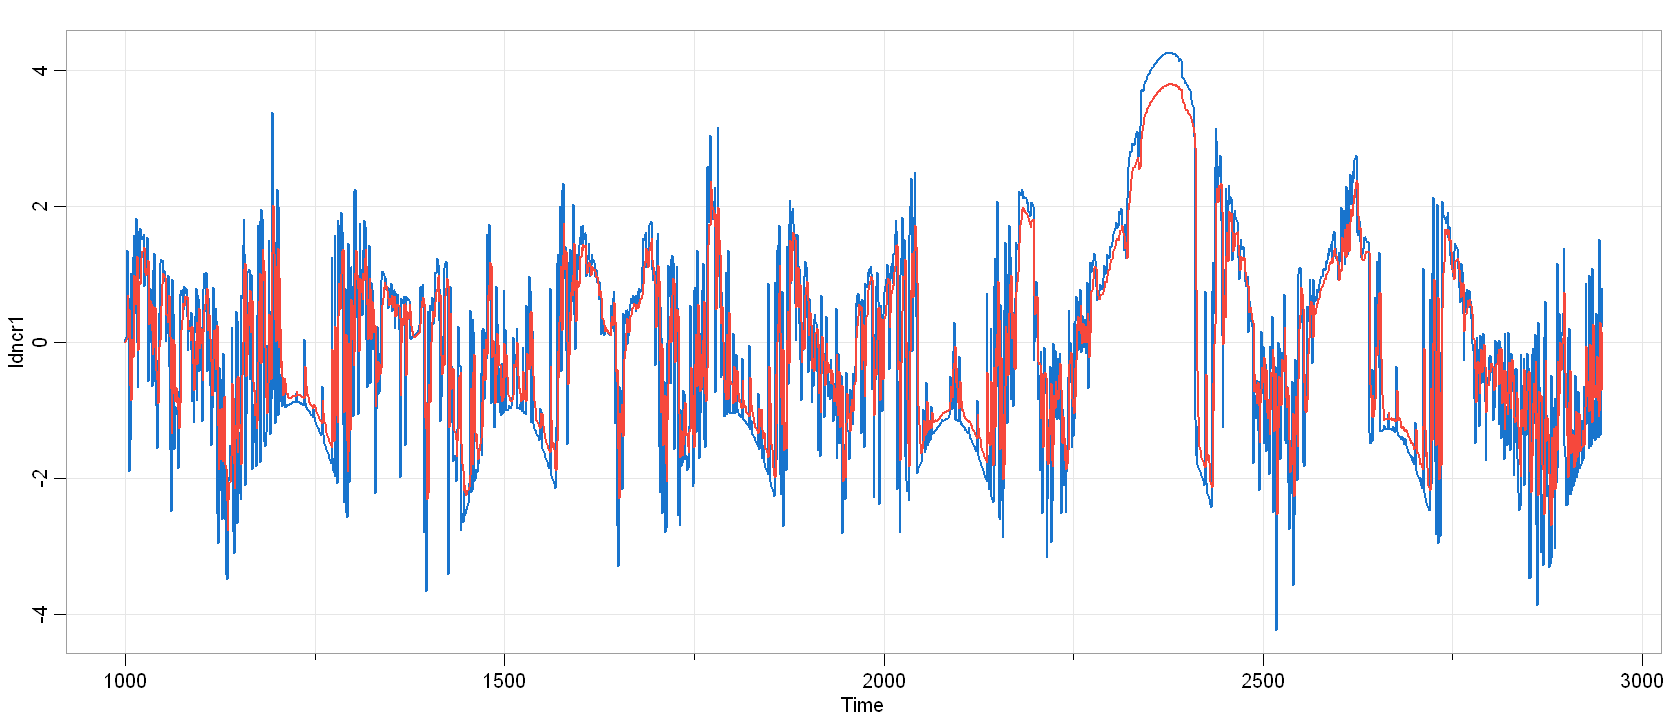

In [47]:
tsplot(ldncr1, col=4, lwd=2)
lines(fitted(fit), col=2, lwd=2)

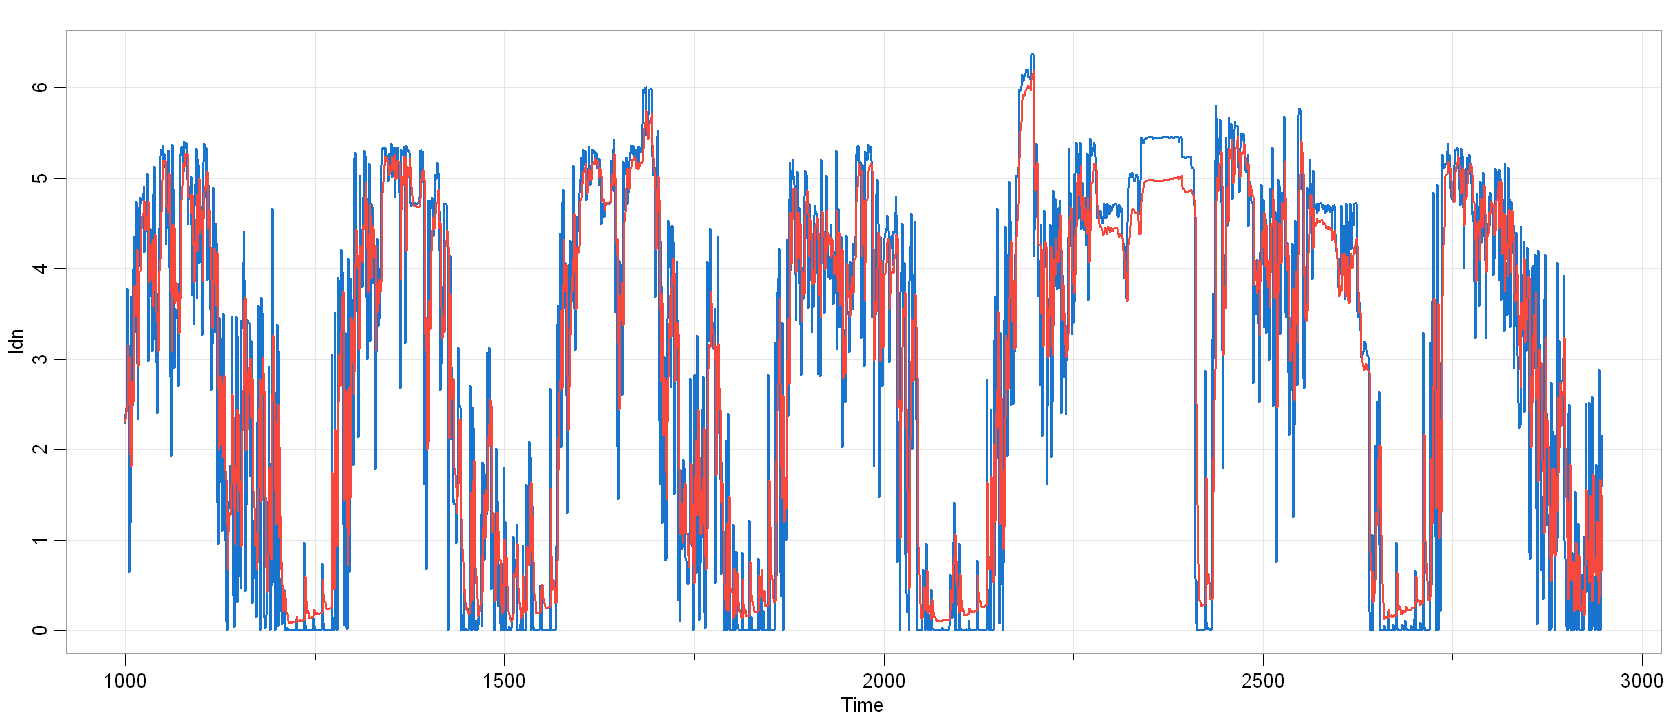

In [48]:
tsplot(ldn, col=4, lwd=2)
lines(predicttrend+prediction+fitted(fit), , col=2, lwd=2)

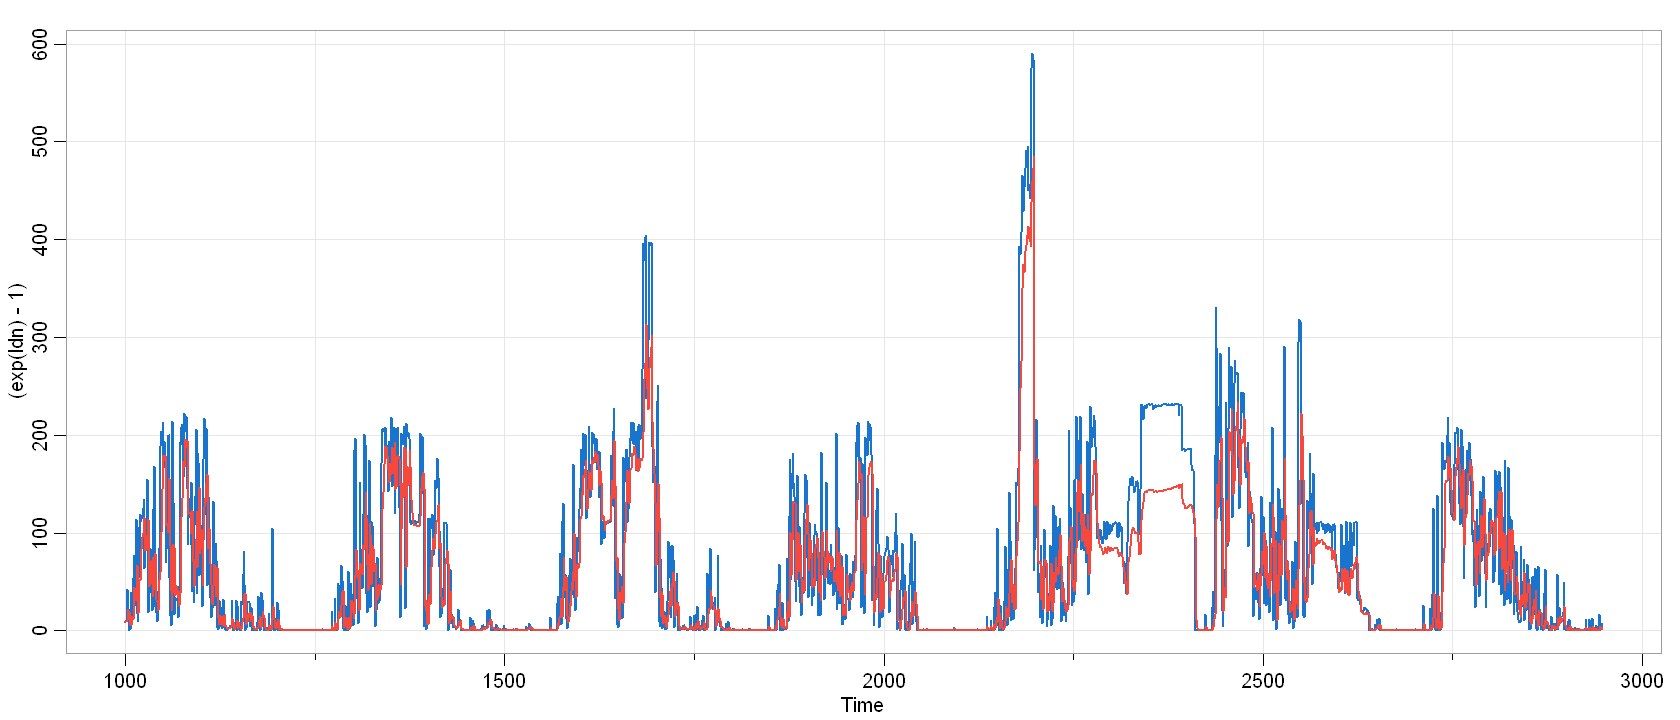

In [49]:
tsplot((exp(ldn)-1), col=4, lwd=2)
lines((exp(predicttrend+prediction+fitted(fit))-1), , col=2, lwd=2)

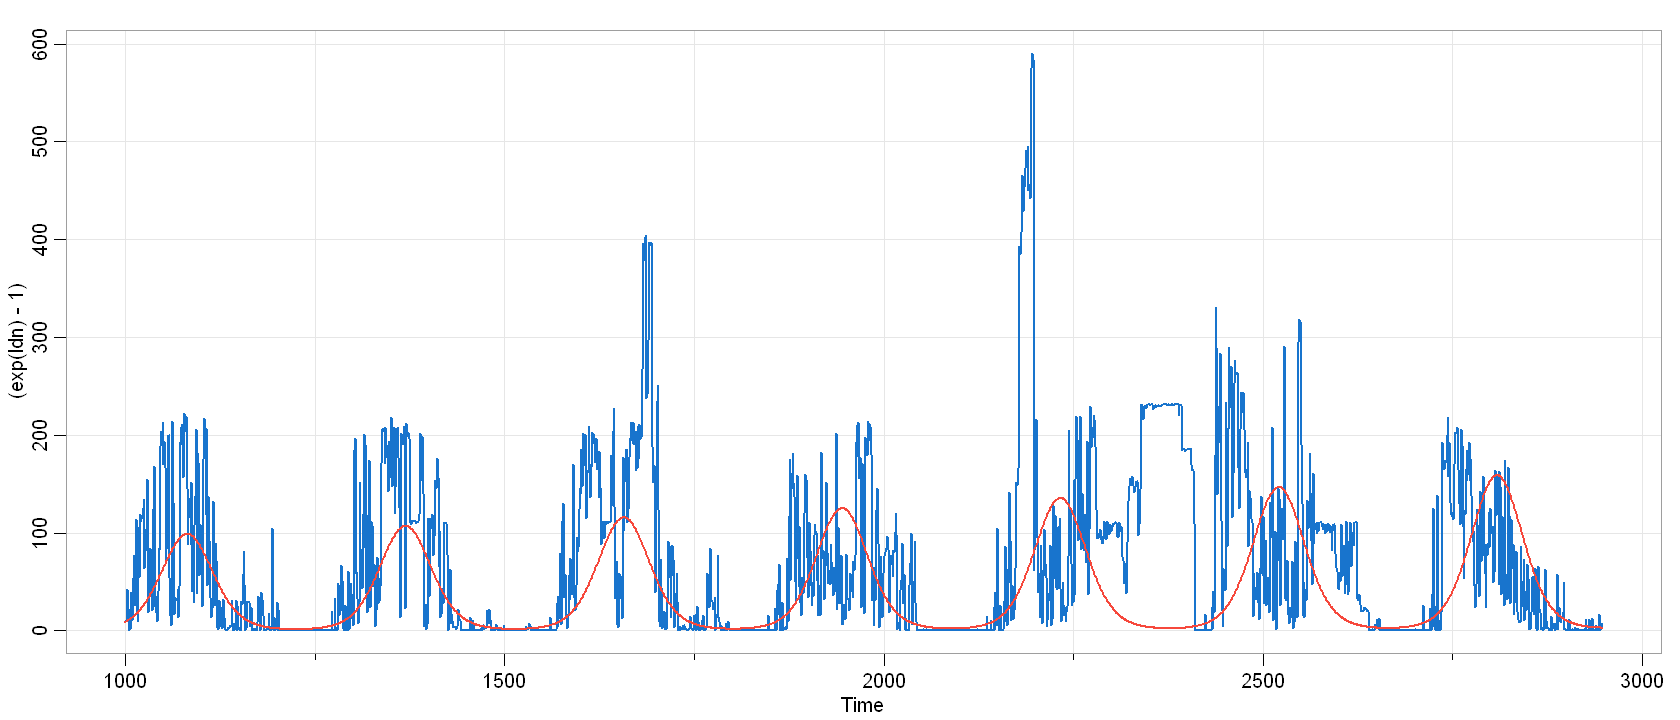

In [50]:
tsplot((exp(ldn)-1), col=4, lwd=2)
lines((exp(predicttrend+prediction)-1), , col=2, lwd=2)

In [46]:
#testv <- train_predict(6500-6400, 6500, ts_df)
#testv